# 🔬 Klasifikasi Penyakit Kulit Wajah dengan Deep Learning
## Menggunakan CNN dan Transfer Learning

Notebook ini mengimplementasikan sistem klasifikasi penyakit kulit wajah menggunakan:
- **Transfer Learning** dengan MobileNetV2/ResNet50/VGG16
- **Data Augmentation** untuk meningkatkan generalisasi
- **Advanced Training Techniques** (callbacks, learning rate scheduling)
- **Comprehensive Evaluation Metrics**

**Asumsi:** Gambar input sudah fokus pada area wajah/penyakit kulit

---

## 📦 1. Setup dan Instalasi Library

Instalasi dan import semua library yang diperlukan.

In [1]:
# Instalasi library (uncomment jika diperlukan)
# !pip install tensorflow
# !pip install scikit-learn
# !pip install matplotlib
# !pip install seaborn
# !pip install pillow
# !pip install numpy
# !pip install pandas

In [2]:
# Import library
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import random
from collections import Counter
import json
from datetime import datetime

# TensorFlow dan Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import (
    Dense, Dropout, GlobalAveragePooling2D, 
    BatchNormalization, Activation, Input
)
from tensorflow.keras.applications import (
    MobileNetV2, ResNet50, VGG16, EfficientNetB0
)
from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator, load_img, img_to_array
)
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, 
    ModelCheckpoint, TensorBoard
)
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical

# Scikit-learn untuk evaluasi
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    accuracy_score, precision_recall_fscore_support,
    roc_curve, auc, roc_auc_score
)
from sklearn.preprocessing import LabelBinarizer

# Image processing
from PIL import Image
import cv2

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Display versions
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU'))} GPU(s)")
if tf.config.list_physical_devices('GPU'):
    print(f"GPU Device: {tf.config.list_physical_devices('GPU')[0].name}")

TensorFlow version: 2.20.0
Keras version: 3.11.3
GPU Available: 0 GPU(s)


In [3]:
# Set random seeds untuk reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Konfigurasi plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Set TensorFlow memory growth (untuk GPU)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU memory growth enabled")
    except RuntimeError as e:
        print(f"⚠️ {e}")

## ⚙️ 2. Konfigurasi Parameter

Definisikan semua hyperparameter dan path dataset.

In [4]:
# ========================================
# KONFIGURASI PATH DATASET
# ========================================

# Untuk Google Colab: mount Google Drive terlebih dahulu
USE_GOOGLE_DRIVE = False  # Set True jika menggunakan Google Drive

if USE_GOOGLE_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive')
    DATASET_PATH = '/content/drive/MyDrive/skin_disease_dataset'
else:
    # Untuk lokal/Jupyter
    DATASET_PATH = './dataset/augmented'

# Struktur folder dataset yang diharapkan:
# skin_disease_dataset/
#   ├── Healthy/
#   │   ├── img1.jpg
#   │   └── img2.jpg
#   ├── Acne_Mild/
#   ├── Acne_Severe/
#   ├── Eczema/
#   ├── Rosacea/
#   ├── Melasma/
#   ├── Psoriasis/
#   ├── Vitiligo/
#   ├── Seborrheic_Dermatitis/
#   └── Contact_Dermatitis/

# Path untuk menyimpan model dan hasil
OUTPUT_DIR = './output_training'
MODEL_SAVE_PATH = os.path.join(OUTPUT_DIR, 'best_model.h5')
HISTORY_SAVE_PATH = os.path.join(OUTPUT_DIR, 'training_history.json')
LOG_DIR = os.path.join(OUTPUT_DIR, 'logs')

# Buat direktori jika belum ada
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)

print(f"📁 Dataset path: {DATASET_PATH}")
print(f"💾 Output directory: {OUTPUT_DIR}")

📁 Dataset path: ./dataset/augmented
💾 Output directory: ./output_training


In [5]:
# ========================================
# HYPERPARAMETER
# ========================================

# Model configuration
BASE_MODEL = 'MobileNetV2'  # Options: 'MobileNetV2', 'ResNet50', 'VGG16', 'EfficientNetB0'
IMG_SIZE = (128, 128)  # Input size untuk model
IMG_SHAPE = (*IMG_SIZE, 3)

# Training parameters
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.0001
VALIDATION_SPLIT = 0.2
TEST_SPLIT = 0.1

# Data augmentation parameters
USE_AUGMENTATION = False
AUGMENTATION_STRENGTH = 'medium'  # 'light', 'medium', 'heavy'

# Model training strategy
FINE_TUNE = True  # Jika True, akan unfreeze beberapa layer terakhir
FINE_TUNE_AT = 100  # Layer ke-berapa mulai di-unfreeze

# Class weights (untuk handle imbalanced dataset)
USE_CLASS_WEIGHTS = True

print("✅ Hyperparameters configured:")
print(f"   Base Model: {BASE_MODEL}")
print(f"   Image Size: {IMG_SIZE}")
print(f"   Batch Size: {BATCH_SIZE}")
print(f"   Epochs: {EPOCHS}")
print(f"   Learning Rate: {LEARNING_RATE}")
print(f"   Augmentation: {USE_AUGMENTATION}")
print(f"   Fine-tuning: {FINE_TUNE}")

✅ Hyperparameters configured:
   Base Model: MobileNetV2
   Image Size: (224, 224)
   Batch Size: 32
   Epochs: 50
   Learning Rate: 0.0001
   Augmentation: True
   Fine-tuning: True


## 📊 3. Data Loading dan Exploratory Data Analysis

Load dataset dan analisis distribusi data.

In [6]:
def load_dataset(dataset_path):
    """
    Load dataset dari struktur folder.
    
    Returns:
        images: List of image arrays
        labels: List of label indices
        class_names: List of class names
    """
    images = []
    labels = []
    class_names = []
    
    # Validasi path
    if not os.path.exists(dataset_path):
        print(f"❌ Dataset path tidak ditemukan: {dataset_path}")
        print("\n💡 Pastikan struktur folder sesuai:")
        print("   skin_disease_dataset/")
        print("     ├── Healthy/")
        print("     ├── Acne_Mild/")
        print("     └── ...")
        return None, None, None
    
    # Dapatkan semua kelas (subfolder)
    class_folders = sorted([f for f in os.listdir(dataset_path) 
                           if os.path.isdir(os.path.join(dataset_path, f))])
    
    if len(class_folders) == 0:
        print("❌ Tidak ada folder kelas ditemukan")
        return None, None, None
    
    print(f"\n📂 Ditemukan {len(class_folders)} kelas:")
    for idx, cls in enumerate(class_folders):
        print(f"   {idx}: {cls}")
    
    print("\n🔄 Loading images...")
    
    # Load images
    for class_idx, class_name in enumerate(class_folders):
        class_path = os.path.join(dataset_path, class_name)
        class_names.append(class_name)
        
        # Dapatkan semua gambar
        image_files = [f for f in os.listdir(class_path)
                      if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
        
        print(f"   Loading {class_name}: {len(image_files)} images", end='')
        
        loaded = 0
        for img_file in image_files:
            img_path = os.path.join(class_path, img_file)
            
            try:
                # Load dan resize image
                img = load_img(img_path, target_size=IMG_SIZE)
                img_array = img_to_array(img)
                
                images.append(img_array)
                labels.append(class_idx)
                loaded += 1
            except Exception as e:
                print(f"\n   ⚠️ Error loading {img_file}: {e}")
        
        print(f" → ✅ {loaded} loaded")
    
    print(f"\n✅ Total loaded: {len(images)} images from {len(class_names)} classes")
    
    return np.array(images), np.array(labels), class_names

# Load dataset
X, y, class_names = load_dataset(DATASET_PATH)


📂 Ditemukan 5 kelas:
   0: Eczemea
   1: Melasma
   2: Rosacea
   3: Seborrhoeic Dermatitis
   4: Vitiligo

🔄 Loading images...
   Loading Eczemea: 121 images → ✅ 121 loaded
   Loading Melasma: 121 images → ✅ 121 loaded
   Loading Rosacea: 121 images → ✅ 121 loaded
   Loading Seborrhoeic Dermatitis: 121 images → ✅ 121 loaded
   Loading Vitiligo: 121 images → ✅ 121 loaded

✅ Total loaded: 605 images from 5 classes


In [7]:
# Validasi dataset
if X is None or len(X) == 0:
    print("\n❌ Dataset tidak dapat dimuat. Silakan periksa path dan struktur folder.")
    print("\n📝 Untuk membuat dataset dummy untuk testing:")
    print("   1. Buat folder: skin_disease_dataset/")
    print("   2. Buat subfolder untuk setiap kelas")
    print("   3. Masukkan gambar ke dalam folder yang sesuai")
else:
    print("\n📊 DATASET SUMMARY:")
    print("="*60)
    print(f"  Total samples: {len(X)}")
    print(f"  Image shape: {X[0].shape}")
    print(f"  Number of classes: {len(class_names)}")
    print(f"  Classes: {class_names}")
    print(f"  Data type: {X.dtype}")
    print(f"  Value range: [{X.min():.2f}, {X.max():.2f}]")
    print("="*60)


📊 DATASET SUMMARY:
  Total samples: 605
  Image shape: (224, 224, 3)
  Number of classes: 5
  Classes: ['Eczemea', 'Melasma', 'Rosacea', 'Seborrhoeic Dermatitis', 'Vitiligo']
  Data type: float32
  Value range: [0.00, 255.00]


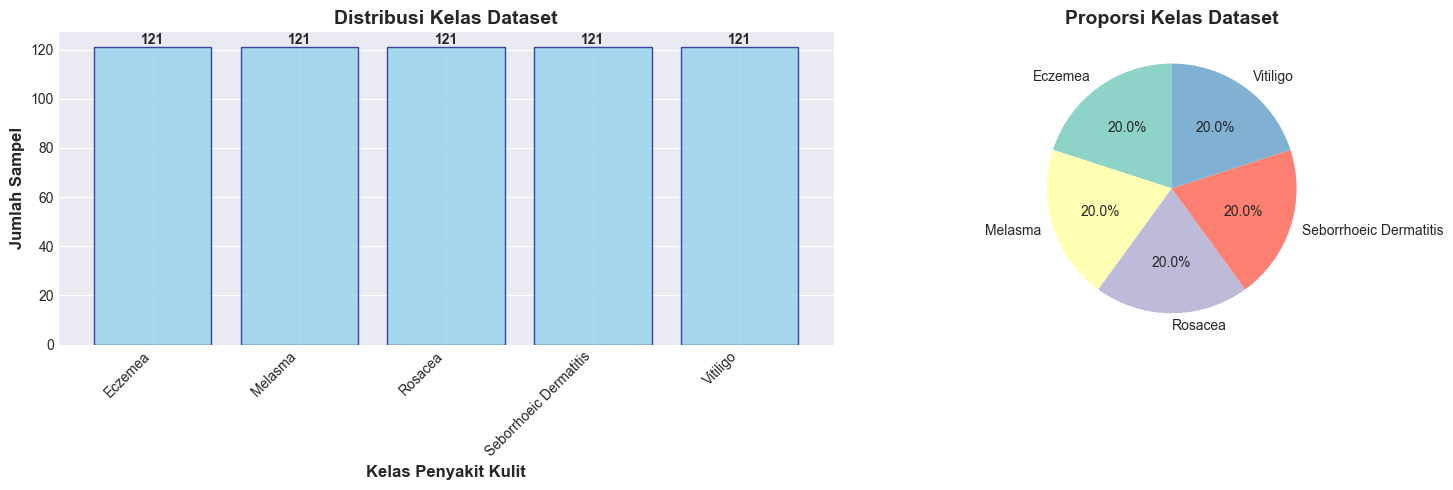


⚖️ CLASS BALANCE ANALYSIS:
   Max samples: 121
   Min samples: 121
   Imbalance ratio: 1.00
   ✅ Dataset reasonably balanced.


In [8]:
# Visualisasi distribusi kelas
if X is not None and len(X) > 0:
    label_counts = Counter(y)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # Bar chart
    ax1 = axes[0]
    counts = [label_counts[i] for i in range(len(class_names))]
    bars = ax1.bar(class_names, counts, color='skyblue', edgecolor='navy', alpha=0.7)
    ax1.set_xlabel('Kelas Penyakit Kulit', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Jumlah Sampel', fontsize=12, fontweight='bold')
    ax1.set_title('Distribusi Kelas Dataset', fontsize=14, fontweight='bold')
    ax1.tick_params(axis='x', rotation=45)
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Tambahkan nilai di atas bar
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontweight='bold')
    
    # Pie chart
    ax2 = axes[1]
    colors = plt.cm.Set3(range(len(class_names)))
    ax2.pie(counts, labels=class_names, autopct='%1.1f%%', startangle=90,
            colors=colors)
    ax2.set_title('Proporsi Kelas Dataset', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'class_distribution.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    # Check class imbalance
    max_count = max(counts)
    min_count = min(counts)
    imbalance_ratio = max_count / min_count
    
    print(f"\n⚖️ CLASS BALANCE ANALYSIS:")
    print(f"   Max samples: {max_count}")
    print(f"   Min samples: {min_count}")
    print(f"   Imbalance ratio: {imbalance_ratio:.2f}")
    
    if imbalance_ratio > 3:
        print(f"   ⚠️ Dataset significantly imbalanced! Consider using class weights.")
    else:
        print(f"   ✅ Dataset reasonably balanced.")

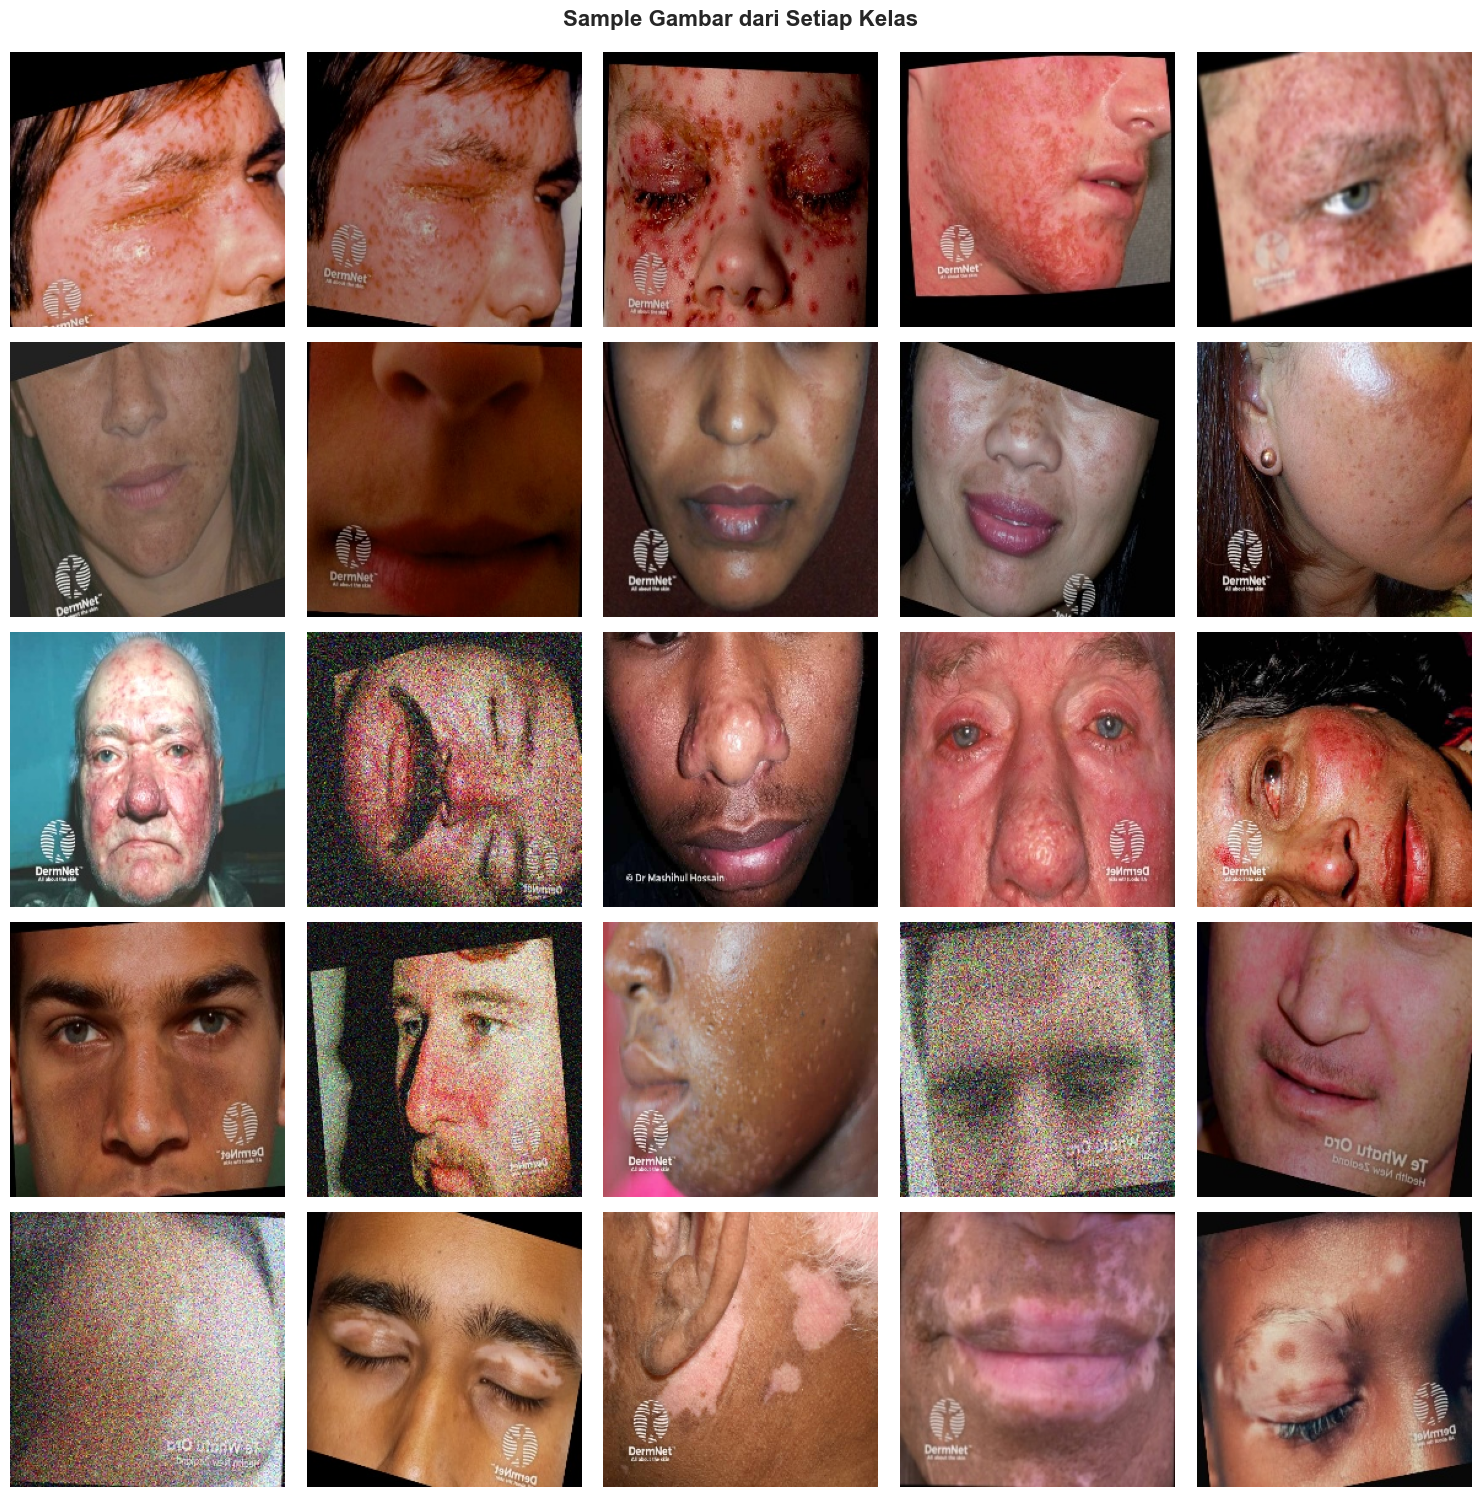

In [9]:
# Visualisasi sample images dari setiap kelas
if X is not None and len(X) > 0:
    n_classes = len(class_names)
    n_samples_per_class = 5
    
    fig, axes = plt.subplots(n_classes, n_samples_per_class, 
                             figsize=(15, 3 * n_classes))
    
    for class_idx in range(n_classes):
        # Get indices untuk kelas ini
        class_indices = np.where(y == class_idx)[0]
        
        # Pilih random samples
        if len(class_indices) >= n_samples_per_class:
            sample_indices = np.random.choice(class_indices, n_samples_per_class, replace=False)
        else:
            sample_indices = class_indices
        
        for sample_idx, img_idx in enumerate(sample_indices[:n_samples_per_class]):
            if n_classes > 1:
                ax = axes[class_idx, sample_idx]
            else:
                ax = axes[sample_idx]
            
            # Display image
            img = X[img_idx].astype('uint8')
            ax.imshow(img)
            ax.axis('off')
            
            # Label untuk kolom pertama
            if sample_idx == 0:
                ax.set_ylabel(class_names[class_idx], 
                            fontsize=11, fontweight='bold', rotation=0, 
                            ha='right', va='center')
    
    plt.suptitle('Sample Gambar dari Setiap Kelas', 
                fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'sample_images.png'), dpi=300, bbox_inches='tight')
    plt.show()

## 🔄 4. Data Preprocessing dan Augmentation

Preprocessing data dan setup data augmentation untuk training.

In [10]:
# Normalisasi data
if X is not None and len(X) > 0:
    print("🔄 Normalizing data...")
    
    # Normalisasi ke [0, 1]
    X_normalized = X.astype('float32') / 255.0
    
    print(f"✅ Data normalized")
    print(f"   Original range: [{X.min()}, {X.max()}]")
    print(f"   Normalized range: [{X_normalized.min():.3f}, {X_normalized.max():.3f}]")

🔄 Normalizing data...
✅ Data normalized
   Original range: [0.0, 255.0]
   Normalized range: [0.000, 1.000]


In [11]:
# Split dataset: Train, Validation, Test
if X is not None and len(X) > 0:
    print("\n📊 Splitting dataset...")
    
    # Split train and temp (val + test)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X_normalized, y,
        test_size=(VALIDATION_SPLIT + TEST_SPLIT),
        random_state=SEED,
        stratify=y
    )
    
    # Split temp into validation and test
    val_test_ratio = TEST_SPLIT / (VALIDATION_SPLIT + TEST_SPLIT)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp,
        test_size=val_test_ratio,
        random_state=SEED,
        stratify=y_temp
    )
    
    print("\n✅ Dataset split completed:")
    print(f"   Training: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
    print(f"   Validation: {len(X_val)} samples ({len(X_val)/len(X)*100:.1f}%)")
    print(f"   Test: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")
    print(f"   Total: {len(X)} samples")
    
    # Convert labels to categorical (one-hot encoding)
    num_classes = len(class_names)
    y_train_cat = to_categorical(y_train, num_classes)
    y_val_cat = to_categorical(y_val, num_classes)
    y_test_cat = to_categorical(y_test, num_classes)
    
    print(f"\n✅ Labels converted to categorical")
    print(f"   Shape: {y_train_cat.shape}")


📊 Splitting dataset...

✅ Dataset split completed:
   Training: 423 samples (69.9%)
   Validation: 121 samples (20.0%)
   Test: 61 samples (10.1%)
   Total: 605 samples

✅ Labels converted to categorical
   Shape: (423, 5)


In [12]:
# Setup Data Augmentation
if X is not None and len(X) > 0 and USE_AUGMENTATION:
    print("\n🎨 Configuring data augmentation...")
    
    if AUGMENTATION_STRENGTH == 'light':
        train_datagen = ImageDataGenerator(
            rotation_range=10,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True,
            zoom_range=0.1,
            fill_mode='nearest'
        )
    elif AUGMENTATION_STRENGTH == 'medium':
        train_datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True,
            zoom_range=0.2,
            shear_range=0.15,
            brightness_range=[0.8, 1.2],
            fill_mode='nearest'
        )
    else:  # heavy
        train_datagen = ImageDataGenerator(
            rotation_range=30,
            width_shift_range=0.3,
            height_shift_range=0.3,
            horizontal_flip=True,
            vertical_flip=True,
            zoom_range=0.3,
            shear_range=0.2,
            brightness_range=[0.7, 1.3],
            fill_mode='nearest'
        )
    
    # Validation data (no augmentation)
    val_datagen = ImageDataGenerator()
    
    print(f"✅ Data augmentation configured ({AUGMENTATION_STRENGTH})")
    print(f"   Rotation: {train_datagen.rotation_range}°")
    print(f"   Width shift: {train_datagen.width_shift_range}")
    print(f"   Height shift: {train_datagen.height_shift_range}")
    print(f"   Zoom: {train_datagen.zoom_range}")
    print(f"   Horizontal flip: {train_datagen.horizontal_flip}")
else:
    # No augmentation
    train_datagen = ImageDataGenerator()
    val_datagen = ImageDataGenerator()
    print("ℹ️ Data augmentation disabled")


🎨 Configuring data augmentation...
✅ Data augmentation configured (medium)
   Rotation: 20°
   Width shift: 0.2
   Height shift: 0.2
   Zoom: [0.8, 1.2]
   Horizontal flip: True



🎨 Sample augmented images:


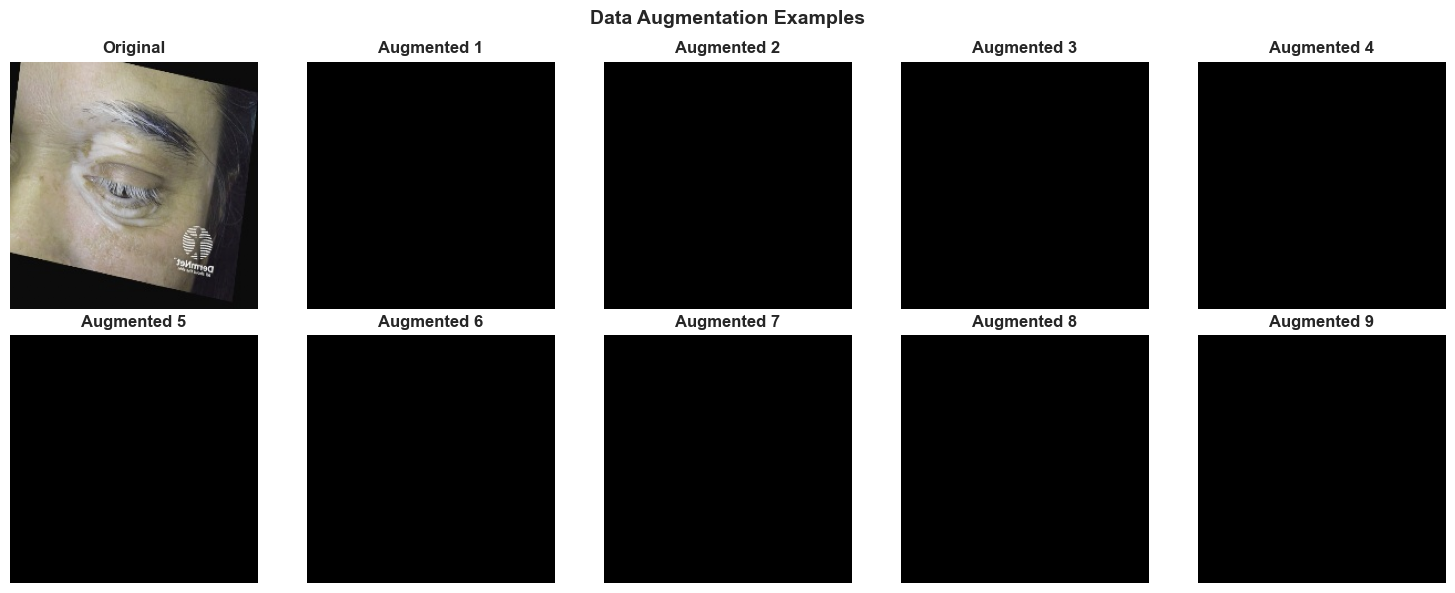

In [13]:
# Visualisasi augmented images (sample)
if X is not None and len(X) > 0 and USE_AUGMENTATION:
    print("\n🎨 Sample augmented images:")
    
    # Pilih satu sample image
    sample_img = X_train[0:1]
    
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.ravel()
    
    # Original image
    axes[0].imshow(sample_img[0])
    axes[0].set_title('Original', fontweight='bold')
    axes[0].axis('off')
    
    # Generate augmented versions
    aug_iter = train_datagen.flow(sample_img, batch_size=1)
    
    for i in range(1, 10):
        aug_img = next(aug_iter)[0]
        axes[i].imshow(aug_img)
        axes[i].set_title(f'Augmented {i}', fontweight='bold')
        axes[i].axis('off')
    
    plt.suptitle('Data Augmentation Examples', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'augmentation_samples.png'), dpi=300, bbox_inches='tight')
    plt.show()

In [14]:
# Calculate class weights untuk handle imbalanced dataset
if X is not None and len(X) > 0 and USE_CLASS_WEIGHTS:
    print("\n⚖️ Calculating class weights...")
    
    from sklearn.utils import class_weight
    
    class_weights_array = class_weight.compute_class_weight(
        'balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    
    class_weights = dict(enumerate(class_weights_array))
    
    print("✅ Class weights computed:")
    for cls_idx, weight in class_weights.items():
        print(f"   {class_names[cls_idx]}: {weight:.3f}")
else:
    class_weights = None
    print("ℹ️ Class weights disabled")


⚖️ Calculating class weights...
✅ Class weights computed:
   Eczemea: 1.007
   Melasma: 0.995
   Rosacea: 0.995
   Seborrhoeic Dermatitis: 1.007
   Vitiligo: 0.995


## 🏗️ 5. Model Building dengan Transfer Learning

Membangun model CNN menggunakan pre-trained model sebagai feature extractor.

In [15]:
def build_model(base_model_name='MobileNetV2', num_classes=10, 
                img_shape=(224, 224, 3), learning_rate=0.0001):
    """
    Build CNN model dengan transfer learning.
    
    Args:
        base_model_name: Nama base model ('MobileNetV2', 'ResNet50', 'VGG16', 'EfficientNetB0')
        num_classes: Jumlah kelas output
        img_shape: Shape input image
        learning_rate: Learning rate untuk optimizer
    
    Returns:
        model: Compiled Keras model
    """
    print(f"\n🏗️ Building model with {base_model_name}...")
    
    # Load pre-trained base model
    if base_model_name == 'MobileNetV2':
        base_model = MobileNetV2(
            input_shape=img_shape,
            include_top=False,
            weights='imagenet'
        )
    elif base_model_name == 'ResNet50':
        base_model = ResNet50(
            input_shape=img_shape,
            include_top=False,
            weights='imagenet'
        )
    elif base_model_name == 'VGG16':
        base_model = VGG16(
            input_shape=img_shape,
            include_top=False,
            weights='imagenet'
        )
    elif base_model_name == 'EfficientNetB0':
        base_model = EfficientNetB0(
            input_shape=img_shape,
            include_top=False,
            weights='imagenet'
        )
    else:
        raise ValueError(f"Unknown base model: {base_model_name}")
    
    # Freeze base model layers
    base_model.trainable = False
    
    # Build complete model
    inputs = Input(shape=img_shape)
    
    # Base model
    x = base_model(inputs, training=False)
    
    # Classification head
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = BatchNormalization()(x)
    
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs, name=f'{base_model_name}_SkinClassifier')
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=[
            'accuracy',
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall'),
            keras.metrics.AUC(name='auc')
        ]
    )
    
    print(f"\n✅ Model built successfully")
    print(f"   Base model: {base_model_name}")
    print(f"   Total layers: {len(model.layers)}")
    print(f"   Trainable params: {model.count_params():,}")
    
    return model, base_model

In [16]:
# Build model
if X is not None and len(X) > 0:
    model, base_model = build_model(
        base_model_name=BASE_MODEL,
        num_classes=num_classes,
        img_shape=IMG_SHAPE,
        learning_rate=LEARNING_RATE
    )
    
    # Display model summary
    print("\n" + "="*70)
    print("MODEL SUMMARY")
    print("="*70)
    model.summary()


🏗️ Building model with MobileNetV2...

✅ Model built successfully
   Base model: MobileNetV2
   Total layers: 13
   Trainable params: 3,086,917

MODEL SUMMARY


Model: "MobileNetV2_SkinClassifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,086,917 (11.78 MB)

 Trainable params: 824,837 (3.15 MB)

 Non-trainable params: 2,262,080 (8.63 MB)

In [17]:
# Visualisasi arsitektur model
if X is not None and len(X) > 0:
    try:
        keras.utils.plot_model(
            model,
            to_file=os.path.join(OUTPUT_DIR, 'model_architecture.png'),
            show_shapes=True,
            show_layer_names=True,
            rankdir='TB',
            expand_nested=False,
            dpi=96
        )
        print("✅ Model architecture diagram saved")
    except Exception as e:
        print(f"⚠️ Could not create model diagram: {e}")

You must install pydot (`pip install pydot`) for `plot_model` to work.
✅ Model architecture diagram saved


## 🎯 6. Training Configuration dan Callbacks

Setup callbacks untuk monitoring dan optimization training.

In [18]:
# Setup callbacks
if X is not None and len(X) > 0:
    print("\n⚙️ Configuring training callbacks...")
    
    callbacks = [
        # Early stopping
        EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True,
            verbose=1,
            mode='min'
        ),
        
        # Reduce learning rate on plateau
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=7,
            min_lr=1e-7,
            verbose=1,
            mode='min'
        ),
        
        # Model checkpoint - save best model
        ModelCheckpoint(
            MODEL_SAVE_PATH,
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1,
            mode='max'
        ),
        
        # TensorBoard logging
        TensorBoard(
            log_dir=LOG_DIR,
            histogram_freq=1,
            write_graph=True,
            write_images=False,
            update_freq='epoch'
        )
    ]
    
    print("✅ Callbacks configured:")
    print("   - EarlyStopping (patience=15)")
    print("   - ReduceLROnPlateau (factor=0.5, patience=7)")
    print("   - ModelCheckpoint (save best model)")
    print("   - TensorBoard logging")
    print(f"\n💡 To view TensorBoard: tensorboard --logdir={LOG_DIR}")


⚙️ Configuring training callbacks...
✅ Callbacks configured:
   - EarlyStopping (patience=15)
   - ReduceLROnPlateau (factor=0.5, patience=7)
   - ModelCheckpoint (save best model)
   - TensorBoard logging

💡 To view TensorBoard: tensorboard --logdir=./output_training\logs


## 🚀 7. Model Training

Train model dengan data yang sudah diproses.

In [19]:
# Training Phase 1: Transfer Learning (frozen base)
if X is not None and len(X) > 0:
    print("\n" + "="*70)
    print("🚀 PHASE 1: TRAINING WITH FROZEN BASE MODEL")
    print("="*70)
    print(f"Base model: {BASE_MODEL} (frozen)")
    print(f"Epochs: {EPOCHS}")
    print(f"Batch size: {BATCH_SIZE}")
    print(f"Learning rate: {LEARNING_RATE}")
    print(f"Training samples: {len(X_train)}")
    print(f"Validation samples: {len(X_val)}")
    print("="*70 + "\n")
    
    # Start training
    history = model.fit(
        train_datagen.flow(X_train, y_train_cat, batch_size=BATCH_SIZE),
        validation_data=(X_val, y_val_cat),
        epochs=EPOCHS,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1
    )
    
    print("\n" + "="*70)
    print("✅ PHASE 1 TRAINING COMPLETED")
    print("="*70)


🚀 PHASE 1: TRAINING WITH FROZEN BASE MODEL
Base model: MobileNetV2 (frozen)
Epochs: 50
Batch size: 32
Learning rate: 0.0001
Training samples: 423
Validation samples: 121

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 739ms/step - accuracy: 0.2125 - auc: 0.5066 - loss: 2.2114 - precision: 0.2446 - recall: 0.1191
Epoch 1: val_accuracy improved from None to 0.23140, saving model to ./output_training\best_model.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.2175 - auc: 0.5045 - loss: 2.2314 - precision: 0.2260 - recall: 0.1111 - val_accuracy: 0.2314 - val_auc: 0.5190 - val_loss: 1.7357 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 885ms/step - accuracy: 0.2187 - auc: 0.4955 - loss: 2.3645 - precision: 0.1705 - recall: 0.0834
Epoch 2: val_accuracy did not improve from 0.23140
14/14 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.2317 - auc: 0.5100 - loss: 2.2403 - precision: 0.2030 - recall: 0.0969 - val_accuracy: 0.2149 - val_auc: 0.5188 - val_loss: 1.7527 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 706ms/step - accuracy: 0.1996 - auc: 0.5132 - loss: 2.2057 - precision: 0.2037 - recall: 0.1055
Epoch 3: val_accuracy did not improve from 0.23140
14/14 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.2009 - auc: 0.5080 - loss: 2.2252 - preci

In [20]:
# Training Phase 2: Fine-tuning (unfreeze some layers)
if X is not None and len(X) > 0 and FINE_TUNE:
    print("\n" + "="*70)
    print("🔥 PHASE 2: FINE-TUNING")
    print("="*70)
    
    # Unfreeze base model layers
    base_model.trainable = True
    
    # Freeze early layers, unfreeze later layers
    for layer in base_model.layers[:FINE_TUNE_AT]:
        layer.trainable = False
    
    print(f"Base model layers: {len(base_model.layers)}")
    print(f"Frozen layers: {FINE_TUNE_AT}")
    print(f"Trainable layers: {len(base_model.layers) - FINE_TUNE_AT}")
    
    # Recompile with lower learning rate
    fine_tune_lr = LEARNING_RATE / 10
    
    model.compile(
        optimizer=Adam(learning_rate=fine_tune_lr),
        loss='categorical_crossentropy',
        metrics=[
            'accuracy',
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall'),
            keras.metrics.AUC(name='auc')
        ]
    )
    
    print(f"Fine-tuning learning rate: {fine_tune_lr}")
    print(f"Trainable params: {model.count_params():,}")
    print("="*70 + "\n")
    
    # Continue training
    fine_tune_epochs = 20
    total_epochs = len(history.history['loss']) + fine_tune_epochs
    
    history_fine = model.fit(
        train_datagen.flow(X_train, y_train_cat, batch_size=BATCH_SIZE),
        validation_data=(X_val, y_val_cat),
        epochs=total_epochs,
        initial_epoch=len(history.history['loss']),
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1
    )
    
    # Merge histories
    for key in history.history.keys():
        history.history[key].extend(history_fine.history[key])
    
    print("\n" + "="*70)
    print("✅ PHASE 2 FINE-TUNING COMPLETED")
    print("="*70)


🔥 PHASE 2: FINE-TUNING
Base model layers: 154
Frozen layers: 100
Trainable layers: 54
Fine-tuning learning rate: 1e-05
Trainable params: 3,086,917

Epoch 17/36
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2231 - auc: 0.5226 - loss: 2.1650 - precision: 0.2340 - recall: 0.1174
Epoch 17: val_accuracy did not improve from 0.23140
14/14 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.2293 - auc: 0.5140 - loss: 2.2054 - precision: 0.2115 - recall: 0.1040 - val_accuracy: 0.2231 - val_auc: 0.5229 - val_loss: 1.7346 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 18/36
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2111 - auc: 0.5027 - loss: 2.2814 - precision: 0.1741 - recall: 0.0919
Epoch 18: val_accuracy did not improve from 0.23140
14/14 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.2080 - auc: 0.5035 - loss: 2.2539 - precision: 0.1713 - recall: 0.0875 - val_accuracy: 0.2314 - val_auc: 0.5254 - val_loss: 1.7394 - val_precision: 0.0000e+00 

14/14 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.1986 - auc: 0.4977 - loss: 2.2933 - precision: 0.2010 - recall: 0.0993 - val_accuracy: 0.2397 - val_auc: 0.5258 - val_loss: 1.7468 - val_precision: 0.2500 - val_recall: 0.0083 - learning_rate: 1.0000e-05
Epoch 20/36
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 950ms/step - accuracy: 0.1872 - auc: 0.4887 - loss: 2.2959 - precision: 0.1738 - recall: 0.0896
Epoch 20: val_accuracy did not improve from 0.23967
14/14 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.1939 - auc: 0.4891 - loss: 2.3160 - precision: 0.1704 - recall: 0.0898 - val_accuracy: 0.2397 - val_auc: 0.5290 - val_loss: 1.7491 - val_precision: 0.2500 - val_recall: 0.0165 - learning_rate: 1.0000e-05
Epoch 21/36
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 879ms/step - accuracy: 0.1578 - auc: 0.4970 - loss: 2.2643 - precision: 0.1722 - recall: 0.0706
Epoch 21: val_accuracy did not improve from 0.23967
14/14 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.1773 - auc: 0.5002 - loss: 2.2584 - precision: 0.2088

In [21]:
# Save training history
if X is not None and len(X) > 0:
    print("\n💾 Saving training history...")
    
    # Convert to serializable format
    history_dict = {}
    for key, value in history.history.items():
        history_dict[key] = [float(v) for v in value]
    
    with open(HISTORY_SAVE_PATH, 'w') as f:
        json.dump(history_dict, f, indent=2)
    
    print(f"✅ Training history saved to: {HISTORY_SAVE_PATH}")


💾 Saving training history...
✅ Training history saved to: ./output_training\training_history.json


## 📊 8. Training Visualization

Visualisasi training history untuk analisis performa.

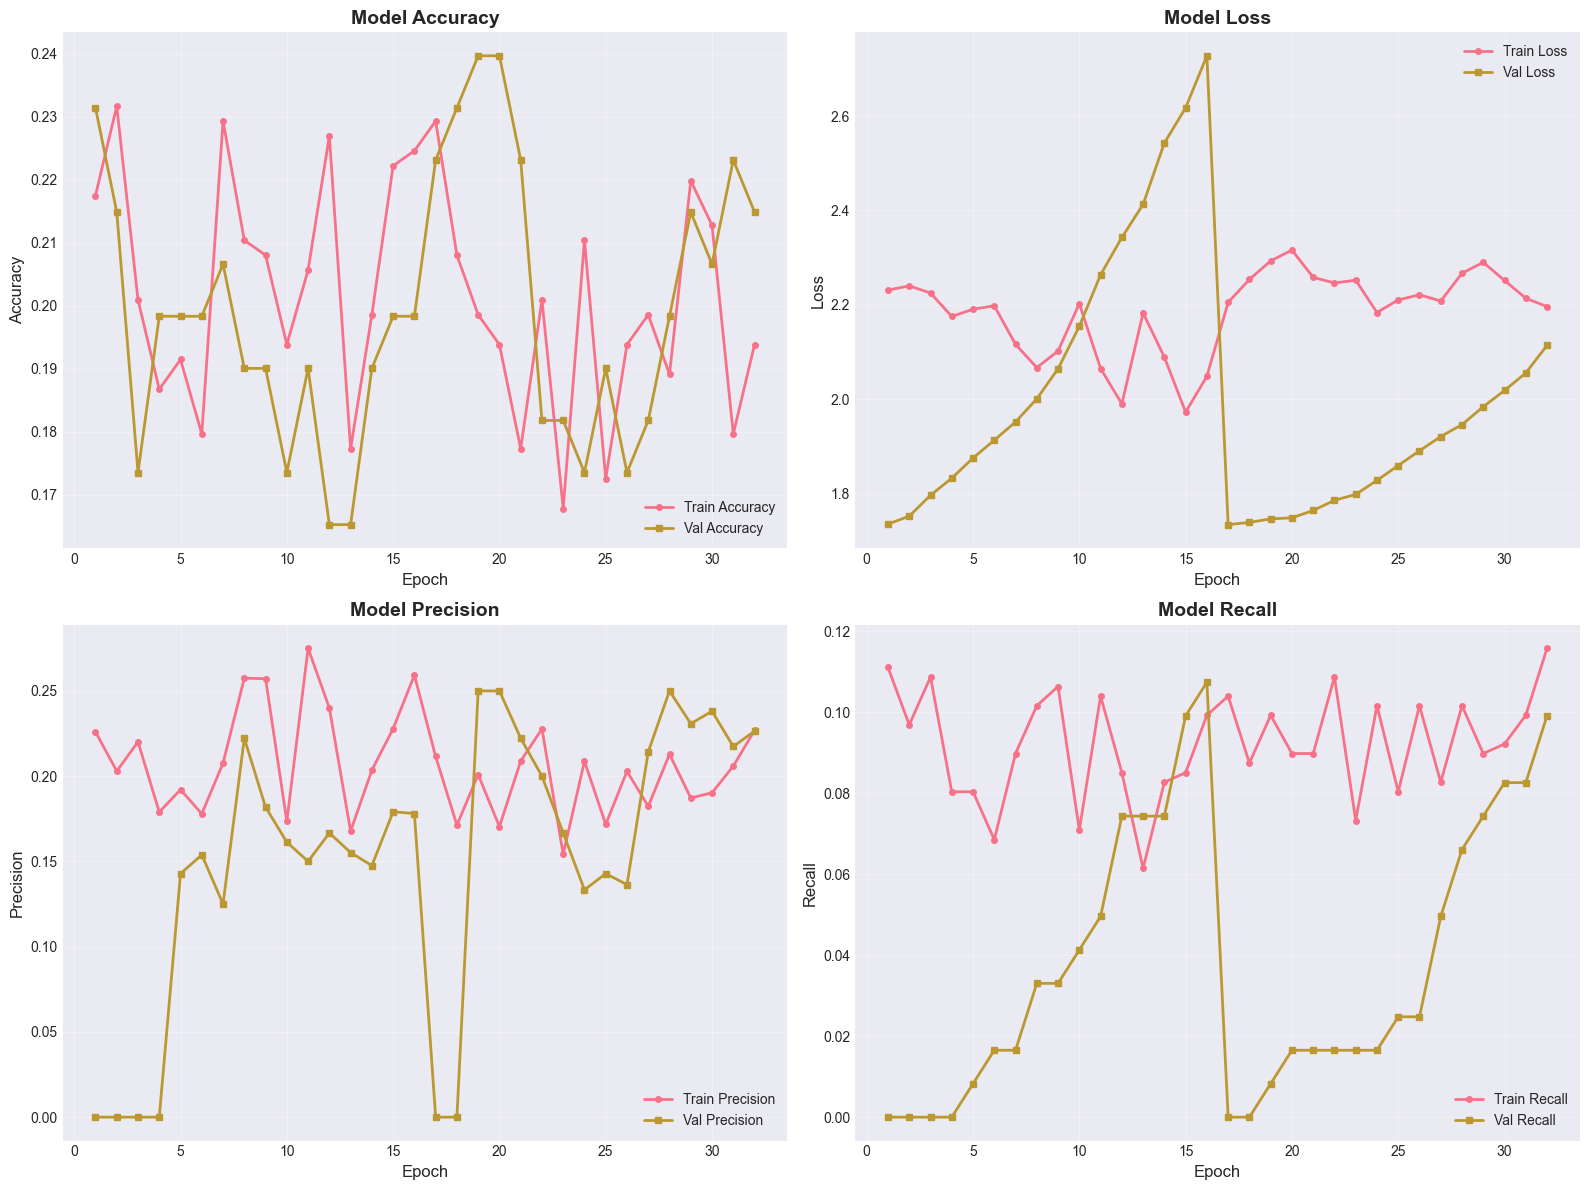

✅ Training history plots saved


In [22]:
# Plot training history
if X is not None and len(X) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    epochs_range = range(1, len(history.history['accuracy']) + 1)
    
    # Accuracy
    axes[0, 0].plot(epochs_range, history.history['accuracy'], 
                    label='Train Accuracy', linewidth=2, marker='o', markersize=4)
    axes[0, 0].plot(epochs_range, history.history['val_accuracy'], 
                    label='Val Accuracy', linewidth=2, marker='s', markersize=4)
    axes[0, 0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch', fontsize=12)
    axes[0, 0].set_ylabel('Accuracy', fontsize=12)
    axes[0, 0].legend(loc='lower right', fontsize=10)
    axes[0, 0].grid(True, alpha=0.3)
    
    # Loss
    axes[0, 1].plot(epochs_range, history.history['loss'], 
                    label='Train Loss', linewidth=2, marker='o', markersize=4)
    axes[0, 1].plot(epochs_range, history.history['val_loss'], 
                    label='Val Loss', linewidth=2, marker='s', markersize=4)
    axes[0, 1].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch', fontsize=12)
    axes[0, 1].set_ylabel('Loss', fontsize=12)
    axes[0, 1].legend(loc='upper right', fontsize=10)
    axes[0, 1].grid(True, alpha=0.3)
    
    # Precision
    axes[1, 0].plot(epochs_range, history.history['precision'], 
                    label='Train Precision', linewidth=2, marker='o', markersize=4)
    axes[1, 0].plot(epochs_range, history.history['val_precision'], 
                    label='Val Precision', linewidth=2, marker='s', markersize=4)
    axes[1, 0].set_title('Model Precision', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch', fontsize=12)
    axes[1, 0].set_ylabel('Precision', fontsize=12)
    axes[1, 0].legend(loc='lower right', fontsize=10)
    axes[1, 0].grid(True, alpha=0.3)
    
    # Recall
    axes[1, 1].plot(epochs_range, history.history['recall'], 
                    label='Train Recall', linewidth=2, marker='o', markersize=4)
    axes[1, 1].plot(epochs_range, history.history['val_recall'], 
                    label='Val Recall', linewidth=2, marker='s', markersize=4)
    axes[1, 1].set_title('Model Recall', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch', fontsize=12)
    axes[1, 1].set_ylabel('Recall', fontsize=12)
    axes[1, 1].legend(loc='lower right', fontsize=10)
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'training_history.png'), 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ Training history plots saved")

## 📈 9. Model Evaluation pada Test Set

Evaluasi performa model pada data test yang belum pernah dilihat.

In [23]:
# Load best model
if X is not None and len(X) > 0:
    print("\n📥 Loading best model...")
    
    if os.path.exists(MODEL_SAVE_PATH):
        model = load_model(MODEL_SAVE_PATH)
        print(f"✅ Best model loaded from: {MODEL_SAVE_PATH}")
    else:
        print("⚠️ Best model file not found, using current model")


📥 Loading best model...


✅ Best model loaded from: ./output_training\best_model.h5


In [24]:
# Evaluate on test set
if X is not None and len(X) > 0:
    print("\n" + "="*70)
    print("🔍 EVALUATING MODEL ON TEST SET")
    print("="*70)
    
    # Predictions
    y_pred_proba = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_proba, axis=1)
    
    # Evaluate
    test_results = model.evaluate(X_test, y_test_cat, verbose=0)
    
    # Extract metrics
    test_loss = test_results[0]
    test_accuracy = test_results[1]
    test_precision = test_results[2]
    test_recall = test_results[3]
    test_auc = test_results[4]
    
    # Calculate F1 score
    precision, recall, f1, support = precision_recall_fscore_support(
        y_test, y_pred, average='weighted', zero_division=0
    )
    
    print(f"\n📊 TEST SET METRICS:")
    print(f"   Loss: {test_loss:.4f}")
    print(f"   Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    print(f"   Precision: {test_precision:.4f}")
    print(f"   Recall: {test_recall:.4f}")
    print(f"   F1-Score: {f1:.4f}")
    print(f"   AUC: {test_auc:.4f}")
    print("="*70)


🔍 EVALUATING MODEL ON TEST SET

📊 TEST SET METRICS:
   Loss: 1.8536
   Accuracy: 0.1639 (16.39%)
   Precision: 0.0000
   Recall: 0.0000
   F1-Score: 0.1371
   AUC: 0.4416


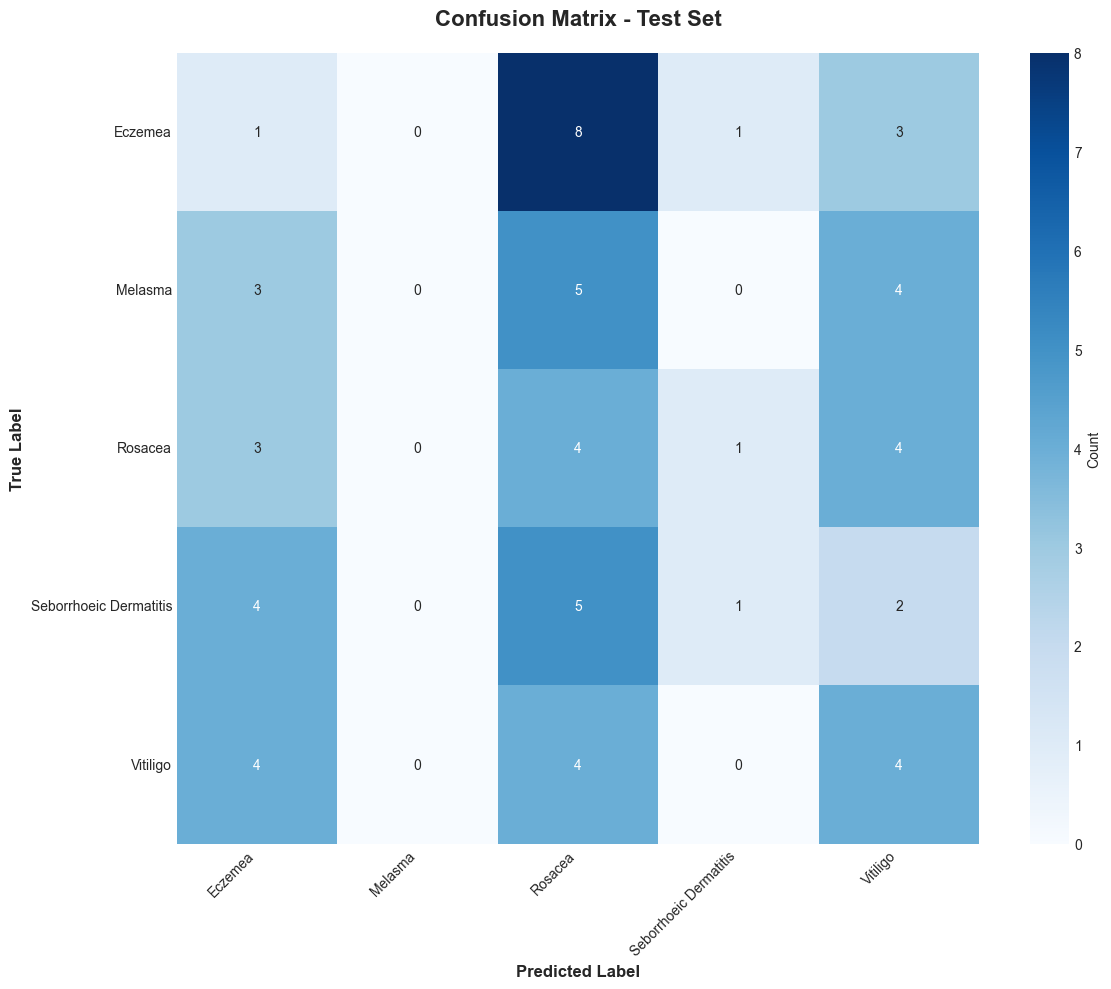

✅ Confusion matrix saved


In [25]:
# Confusion Matrix
if X is not None and len(X) > 0:
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title('Confusion Matrix - Test Set', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
    plt.ylabel('True Label', fontsize=12, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrix.png'), 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ Confusion matrix saved")

In [26]:
# Classification Report
if X is not None and len(X) > 0:
    print("\n" + "="*70)
    print("📋 CLASSIFICATION REPORT")
    print("="*70)
    print(classification_report(y_test, y_pred, target_names=class_names, digits=4))
    print("="*70)


📋 CLASSIFICATION REPORT
                        precision    recall  f1-score   support

               Eczemea     0.0667    0.0769    0.0714        13
               Melasma     0.0000    0.0000    0.0000        12
               Rosacea     0.1538    0.3333    0.2105        12
Seborrhoeic Dermatitis     0.3333    0.0833    0.1333        12
              Vitiligo     0.2353    0.3333    0.2759        12

              accuracy                         0.1639        61
             macro avg     0.1578    0.1654    0.1382        61
          weighted avg     0.1563    0.1639    0.1371        61



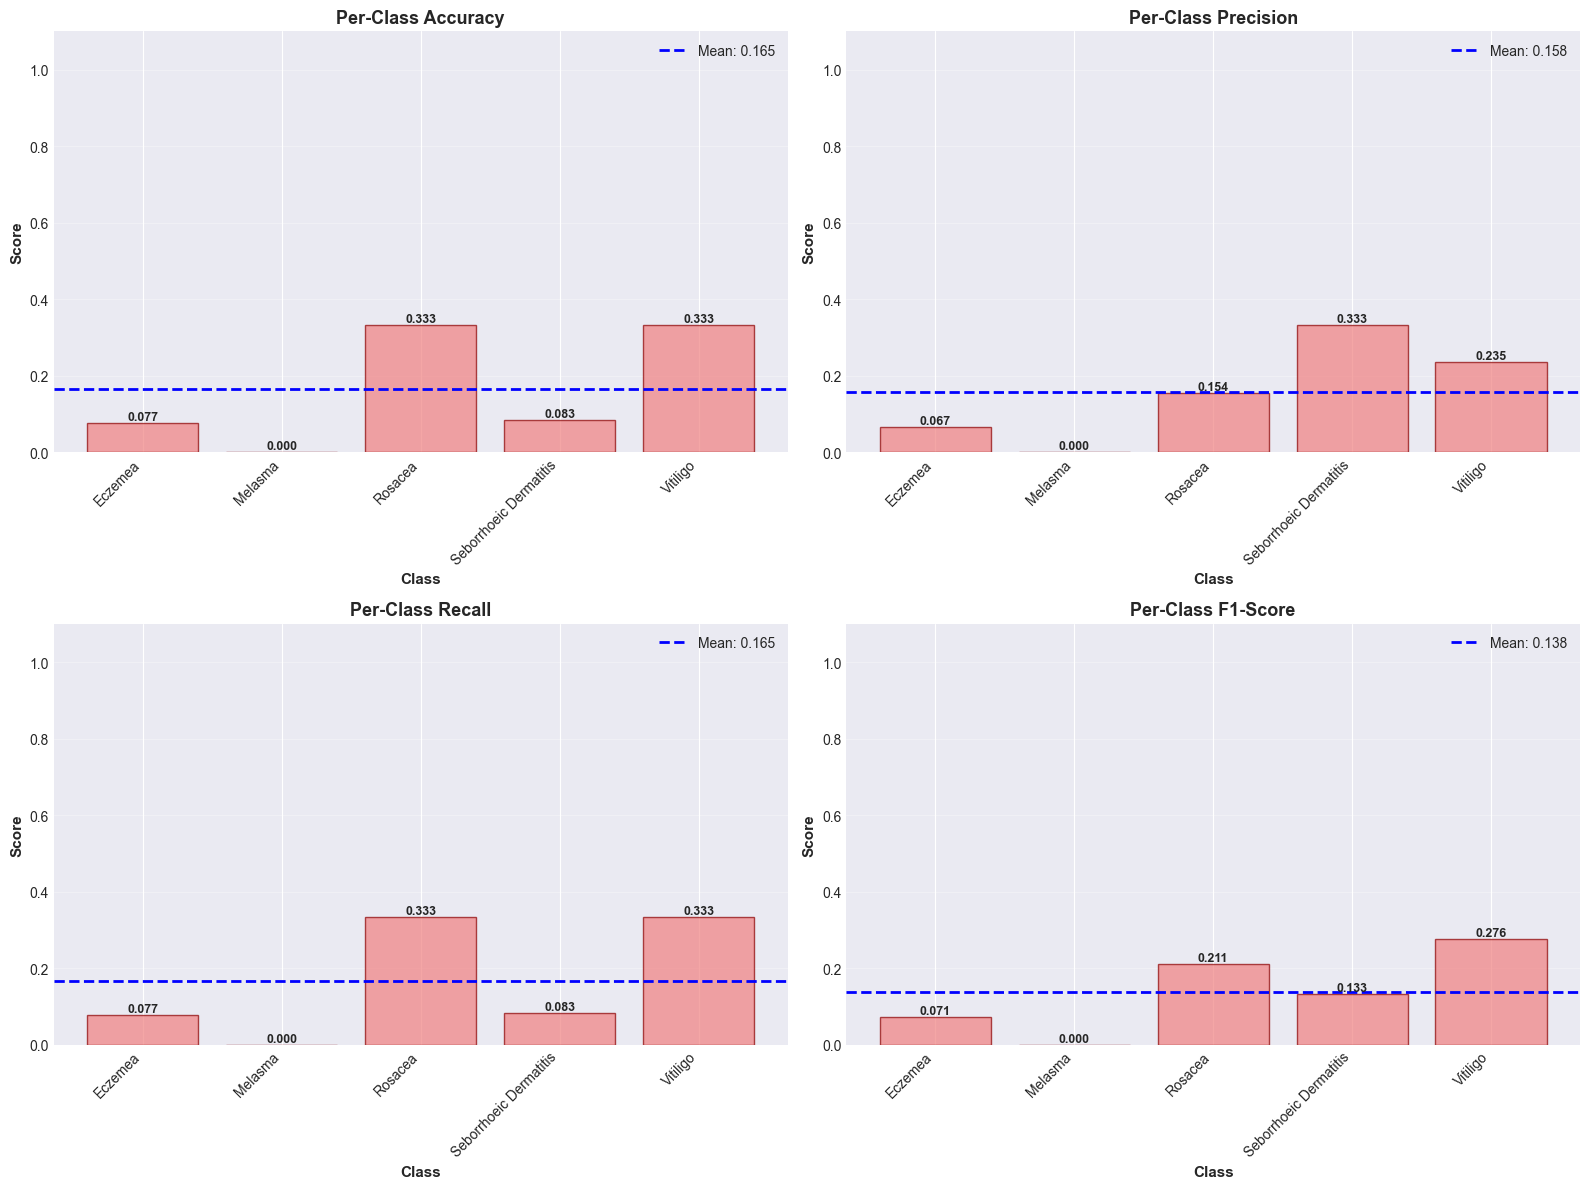

✅ Per-class metrics plots saved


In [28]:
# Per-class metrics visualization
if X is not None and len(X) > 0:
    # Calculate per-class accuracy
    per_class_accuracy = []
    per_class_precision = []
    per_class_recall = []
    per_class_f1 = []
    
    for i in range(num_classes):
        mask = y_test == i
        if mask.sum() > 0:
            # Accuracy
            acc = (y_pred[mask] == y_test[mask]).sum() / mask.sum()
            per_class_accuracy.append(acc)
            
            # Other metrics
            # Hitung semua metrics sekaligus untuk semua kelas
            p_all, r_all, f_all, support = precision_recall_fscore_support(
                y_test, y_pred, average=None, zero_division=0  # ✅ FIXED
            )

            # Gunakan hasil untuk setiap kelas
            per_class_precision.append(p_all[i])
            per_class_recall.append(r_all[i])
            per_class_f1.append(f_all[i])
        else:
            per_class_accuracy.append(0)
            per_class_precision.append(0)
            per_class_recall.append(0)
            per_class_f1.append(0)
    
    # Plot per-class metrics
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    metrics = [
        (per_class_accuracy, 'Per-Class Accuracy', axes[0, 0]),
        (per_class_precision, 'Per-Class Precision', axes[0, 1]),
        (per_class_recall, 'Per-Class Recall', axes[1, 0]),
        (per_class_f1, 'Per-Class F1-Score', axes[1, 1])
    ]
    
    for metric_values, title, ax in metrics:
        bars = ax.bar(class_names, metric_values, color='lightcoral', 
                     edgecolor='darkred', alpha=0.7)
        ax.axhline(y=np.mean(metric_values), color='blue', linestyle='--', 
                  linewidth=2, label=f'Mean: {np.mean(metric_values):.3f}')
        ax.set_xlabel('Class', fontsize=11, fontweight='bold')
        ax.set_ylabel('Score', fontsize=11, fontweight='bold')
        ax.set_title(title, fontsize=13, fontweight='bold')
        ax.set_xticklabels(class_names, rotation=45, ha='right')
        ax.set_ylim([0, 1.1])
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y')
        
        # Add value labels
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}',
                   ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'per_class_metrics.png'), 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ Per-class metrics plots saved")

## 🔮 10. Prediction Pipeline

Implementasi fungsi untuk prediksi pada gambar baru.

In [29]:
def predict_skin_disease(image_path, model, class_names, img_size=(224, 224), visualize=True):
    """
    Prediksi penyakit kulit dari gambar.
    
    Args:
        image_path: Path ke gambar input
        model: Model Keras untuk prediksi
        class_names: List nama kelas
        img_size: Ukuran input model
        visualize: Jika True, tampilkan visualisasi
    
    Returns:
        result: Dictionary berisi hasil prediksi
    """
    result = {
        'success': False,
        'image_path': image_path,
        'predicted_class': None,
        'confidence': None,
        'all_probabilities': None
    }
    
    try:
        # Load image
        img = load_img(image_path, target_size=img_size)
        img_array = img_to_array(img)
        
        # Preprocess
        img_normalized = img_array / 255.0
        img_batch = np.expand_dims(img_normalized, axis=0)
        
        # Predict
        predictions = model.predict(img_batch, verbose=0)[0]
        predicted_class_idx = np.argmax(predictions)
        predicted_class = class_names[predicted_class_idx]
        confidence = predictions[predicted_class_idx]
        
        # Store results
        result['success'] = True
        result['predicted_class'] = predicted_class
        result['confidence'] = float(confidence)
        result['all_probabilities'] = {
            class_names[i]: float(predictions[i]) 
            for i in range(len(class_names))
        }
        
        # Visualize
        if visualize:
            fig, axes = plt.subplots(1, 2, figsize=(15, 6))
            
            # Image
            axes[0].imshow(img)
            axes[0].set_title(f'Input Image', fontsize=13, fontweight='bold')
            axes[0].axis('off')
            
            # Prediction probabilities
            sorted_indices = np.argsort(predictions)[::-1]
            sorted_classes = [class_names[i] for i in sorted_indices]
            sorted_probs = [predictions[i] for i in sorted_indices]
            
            y_pos = np.arange(len(class_names))
            colors = ['green' if i == predicted_class_idx else 'lightblue' 
                     for i in sorted_indices]
            
            axes[1].barh(y_pos, sorted_probs, color=colors, edgecolor='navy', alpha=0.7)
            axes[1].set_yticks(y_pos)
            axes[1].set_yticklabels(sorted_classes)
            axes[1].set_xlabel('Probability', fontsize=11, fontweight='bold')
            axes[1].set_title(
                f'Prediction: {predicted_class}\nConfidence: {confidence:.2%}',
                fontsize=13, fontweight='bold'
            )
            axes[1].set_xlim([0, 1])
            axes[1].grid(True, alpha=0.3, axis='x')
            
            # Add percentage labels
            for i, (prob, color) in enumerate(zip(sorted_probs, colors)):
                axes[1].text(prob + 0.02, i, f'{prob:.1%}',
                           va='center', fontweight='bold', fontsize=9)
            
            plt.tight_layout()
            plt.show()
        
        return result
    
    except Exception as e:
        print(f"❌ Error predicting {image_path}: {e}")
        return result

print("✅ Prediction function defined")

✅ Prediction function defined



🔮 TESTING PREDICTION ON SAMPLE IMAGES

--- Sample 25 ---
True Label: Seborrhoeic Dermatitis


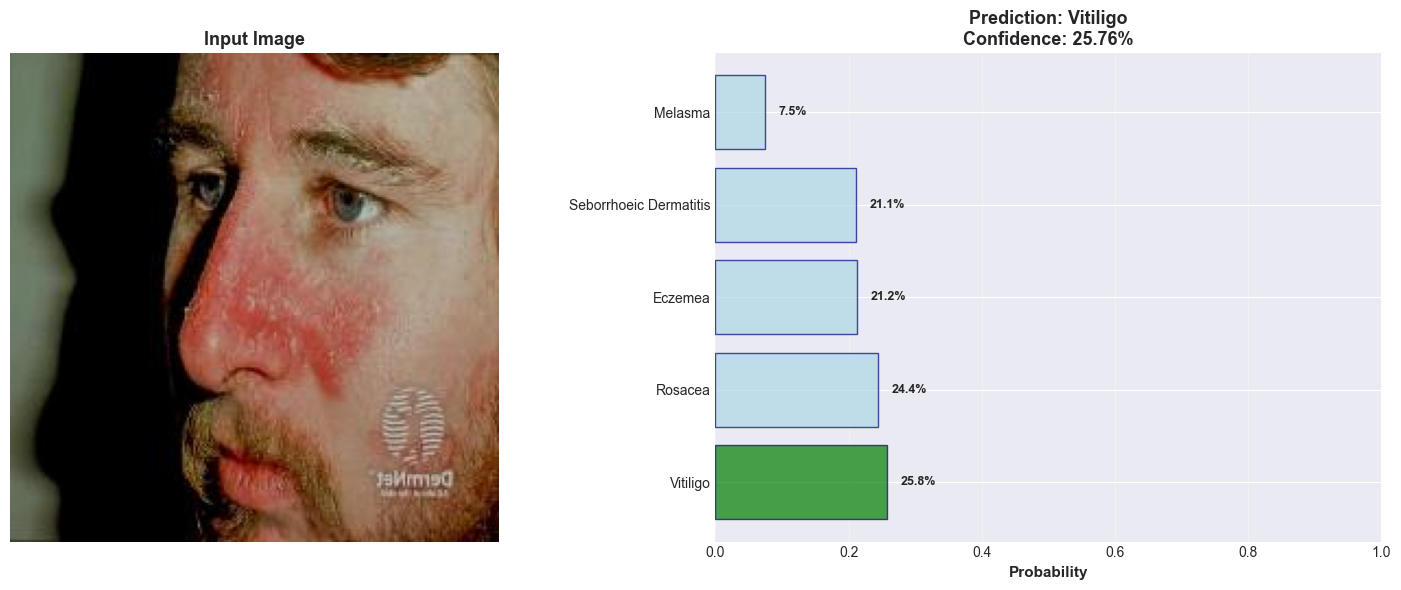

Predicted: Vitiligo (Confidence: 25.76%) ❌ Wrong

--- Sample 9 ---
True Label: Rosacea
Predicted: Vitiligo (Confidence: 33.26%) ❌ Wrong

--- Sample 59 ---
True Label: Rosacea
Predicted: Vitiligo (Confidence: 30.67%) ❌ Wrong



In [30]:
# Test prediction pada sample dari test set
if X is not None and len(X) > 0:
    print("\n" + "="*70)
    print("🔮 TESTING PREDICTION ON SAMPLE IMAGES")
    print("="*70)
    
    # Pilih beberapa random samples
    n_samples = min(3, len(X_test))
    sample_indices = np.random.choice(len(X_test), n_samples, replace=False)
    
    for idx in sample_indices:
        print(f"\n--- Sample {idx+1} ---")
        
        # Save sample to temp file
        temp_img_path = os.path.join(OUTPUT_DIR, f'temp_sample_{idx}.jpg')
        sample_img = (X_test[idx] * 255).astype(np.uint8)
        Image.fromarray(sample_img).save(temp_img_path)
        
        true_label = class_names[y_test[idx]]
        print(f"True Label: {true_label}")
        
        # Predict
        result = predict_skin_disease(temp_img_path, model, class_names, 
                                      img_size=IMG_SIZE, visualize=(idx == sample_indices[0]))
        
        if result['success']:
            pred_label = result['predicted_class']
            confidence = result['confidence']
            
            status = "✅ Correct" if pred_label == true_label else "❌ Wrong"
            print(f"Predicted: {pred_label} (Confidence: {confidence:.2%}) {status}")
        
        # Cleanup temp file
        if os.path.exists(temp_img_path):
            os.remove(temp_img_path)
    
    print("\n" + "="*70)

### Prediction pada Gambar Baru (Custom Input)

In [31]:
# Prediksi pada gambar baru dari user
# Uncomment dan set path untuk melakukan prediksi

# NEW_IMAGE_PATH = './path/to/your/new/image.jpg'
# 
# if os.path.exists(NEW_IMAGE_PATH) and X is not None:
#     print("🔮 Melakukan prediksi pada gambar baru...\n")
#     result = predict_skin_disease(NEW_IMAGE_PATH, model, class_names, 
#                                   img_size=IMG_SIZE, visualize=True)
#     
#     if result['success']:
#         print("\n📊 HASIL PREDIKSI:")
#         print(f"   Penyakit: {result['predicted_class']}")
#         print(f"   Confidence: {result['confidence']:.2%}")
#         print("\n   Top 3 Predictions:")
#         sorted_probs = sorted(result['all_probabilities'].items(), 
#                              key=lambda x: x[1], reverse=True)[:3]
#         for i, (cls, prob) in enumerate(sorted_probs, 1):
#             print(f"     {i}. {cls}: {prob:.2%}")
#     else:
#         print("❌ Prediksi gagal")
# else:
#     print("⚠️ Set NEW_IMAGE_PATH untuk melakukan prediksi pada gambar baru")

## 💾 11. Save Model dan Metadata

Simpan model dan informasi penting untuk deployment.

In [32]:
# Save final model
if X is not None and len(X) > 0:
    print("\n💾 Saving final model and metadata...")
    
    # Save model
    final_model_path = os.path.join(OUTPUT_DIR, 'skin_disease_classifier_final.h5')
    model.save(final_model_path)
    print(f"✅ Model saved: {final_model_path}")
    
    # Save class names
    class_names_path = os.path.join(OUTPUT_DIR, 'class_names.json')
    with open(class_names_path, 'w') as f:
        json.dump(class_names, f, indent=2)
    print(f"✅ Class names saved: {class_names_path}")
    
    # Save model metadata
    metadata = {
        'model_name': f'{BASE_MODEL}_SkinClassifier',
        'base_model': BASE_MODEL,
        'num_classes': num_classes,
        'class_names': class_names,
        'img_size': IMG_SIZE,
        'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'total_samples': len(X),
        'train_samples': len(X_train),
        'val_samples': len(X_val),
        'test_samples': len(X_test),
        'test_accuracy': float(test_accuracy),
        'test_precision': float(test_precision),
        'test_recall': float(test_recall),
        'test_f1': float(f1),
        'test_auc': float(test_auc),
        'hyperparameters': {
            'batch_size': BATCH_SIZE,
            'epochs': EPOCHS,
            'learning_rate': LEARNING_RATE,
            'use_augmentation': USE_AUGMENTATION,
            'augmentation_strength': AUGMENTATION_STRENGTH,
            'fine_tune': FINE_TUNE,
        }
    }
    
    metadata_path = os.path.join(OUTPUT_DIR, 'model_metadata.json')
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2)
    print(f"✅ Metadata saved: {metadata_path}")


💾 Saving final model and metadata...
✅ Model saved: ./output_training\skin_disease_classifier_final.h5
✅ Class names saved: ./output_training\class_names.json
✅ Metadata saved: ./output_training\model_metadata.json


## 📝 12. Summary dan Kesimpulan

Ringkasan hasil training dan panduan deployment.

In [33]:
if X is not None and len(X) > 0:
    print("\n" + "="*70)
    print("📊 PROJECT SUMMARY")
    print("="*70)
    
    print(f"\n🎯 Model: {BASE_MODEL} Skin Disease Classifier")
    
    print(f"\n📂 Dataset:")
    print(f"   Total samples: {len(X)}")
    print(f"   Classes: {len(class_names)}")
    print(f"   Class names: {', '.join(class_names)}")
    print(f"   Split: {len(X_train)} train / {len(X_val)} val / {len(X_test)} test")
    
    print(f"\n🏗️ Model Architecture:")
    print(f"   Base model: {BASE_MODEL}")
    print(f"   Input size: {IMG_SIZE}")
    print(f"   Total parameters: {model.count_params():,}")
    print(f"   Fine-tuning: {'Yes' if FINE_TUNE else 'No'}")
    
    print(f"\n📈 Performance Metrics (Test Set):")
    print(f"   Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    print(f"   Precision: {test_precision:.4f}")
    print(f"   Recall: {test_recall:.4f}")
    print(f"   F1-Score: {f1:.4f}")
    print(f"   AUC: {test_auc:.4f}")
    
    print(f"\n💾 Output Files:")
    print(f"   Model: {final_model_path}")
    print(f"   Best model: {MODEL_SAVE_PATH}")
    print(f"   Class names: {class_names_path}")
    print(f"   Metadata: {metadata_path}")
    print(f"   Training history: {HISTORY_SAVE_PATH}")
    print(f"   Visualizations: {OUTPUT_DIR}/*.png")
    
    print(f"\n🚀 Deployment:")
    print(f"   1. Load model: model = load_model('{final_model_path}')")
    print(f"   2. Load classes: with open('{class_names_path}') as f: classes = json.load(f)")
    print(f"   3. Predict: predict_skin_disease(image_path, model, classes)")
    
    print(f"\n💡 Next Steps:")
    print(f"   - Deploy model as REST API (Flask/FastAPI)")
    print(f"   - Convert to TensorFlow Lite for mobile")
    print(f"   - Create web interface")
    print(f"   - Collect more data for improvement")
    
    print("\n" + "="*70)
    print("✅ PROJECT COMPLETED SUCCESSFULLY!")
    print("="*70 + "\n")
else:
    print("\n" + "="*70)
    print("⚠️ PROJECT INCOMPLETE")
    print("="*70)
    print("\nDataset tidak ditemukan atau tidak valid.")
    print("\nSilakan:")
    print("1. Periksa DATASET_PATH")
    print("2. Pastikan struktur folder benar")
    print("3. Jalankan ulang notebook")
    print("="*70 + "\n")


📊 PROJECT SUMMARY

🎯 Model: MobileNetV2 Skin Disease Classifier

📂 Dataset:
   Total samples: 605
   Classes: 5
   Class names: Eczemea, Melasma, Rosacea, Seborrhoeic Dermatitis, Vitiligo
   Split: 423 train / 121 val / 61 test

🏗️ Model Architecture:
   Base model: MobileNetV2
   Input size: (224, 224)
   Total parameters: 3,086,917
   Fine-tuning: Yes

📈 Performance Metrics (Test Set):
   Accuracy: 0.1639 (16.39%)
   Precision: 0.0000
   Recall: 0.0000
   F1-Score: 0.1371
   AUC: 0.4416

💾 Output Files:
   Model: ./output_training\skin_disease_classifier_final.h5
   Best model: ./output_training\best_model.h5
   Class names: ./output_training\class_names.json
   Metadata: ./output_training\model_metadata.json
   Training history: ./output_training\training_history.json
   Visualizations: ./output_training/*.png

🚀 Deployment:
   1. Load model: model = load_model('./output_training\skin_disease_classifier_final.h5')
   2. Load classes: with open('./output_training\class_names.json') 

---

## 🎓 User Guide

### Quick Start:

1. **Setup Dataset:**
   ```
   skin_disease_dataset/
   ├── Healthy/
   ├── Acne_Mild/
   ├── Acne_Severe/
   └── ...
   ```

2. **Configure Parameters:** Edit section 2 (Konfigurasi Parameter)

3. **Run All Cells:** Cell → Run All

4. **Monitor Training:** Check TensorBoard or training plots

5. **Evaluate Results:** Check test metrics and confusion matrix

6. **Deploy:** Use saved model for predictions

### Tips:

- **GPU Acceleration:** Enable GPU in Colab (Runtime → Change runtime type → GPU)
- **Small Dataset:** Use heavy augmentation and smaller batch size
- **Overfitting:** Increase dropout or add more regularization
- **Low Accuracy:** Try different base models or increase epochs
- **Imbalanced Data:** Use class weights or SMOTE

### Model Selection:

- **MobileNetV2:** Fast, lightweight (best for mobile)
- **ResNet50:** Accurate, medium speed
- **VGG16:** Simple architecture, slower
- **EfficientNetB0:** Best accuracy/efficiency trade-off

### Deployment Options:

1. **REST API:** Flask/FastAPI web service
2. **Mobile App:** TensorFlow Lite conversion
3. **Web App:** TensorFlow.js for browser
4. **Cloud:** Deploy to AWS/GCP/Azure

---

**📧 Support:** For issues or questions, refer to TensorFlow documentation or open an issue.

**Happy Training! 🚀**